# When to Kick for Goal ?

## The Question 

In Rugby when a team wins a penalty they have two options. They can kick for goal or kick for touch. If they choose to kick for goal they could get 3 points but, take on some risk and kick for touch they could get 7 points. The risk of not converting a penalty into points will vary based on the location of the penalty. The tigher the angle and further the distance of a Goal Kick the harder it will be to convert. The closer a kick for touch can setup a Lineout the more likely a Lineout will result in a Try (5 points for a Try with a Goal Kick for an additional 2 points).    

Where on the pitch should a team choice to kick for goal to maximise their total points in a match? 

For the sack of completeness there is a third option of a quick tap but that is seldom taken as its very high risk with the same pay off as kicking to touch so we will ignore it. 


## Short Hand Notation

### Objects

$A^{count}_{\space \space \space \space event}$ represents an action either by a player or group of players in a sequence. The super-script represent the order in the sequence and the sub-script the type of action.

$S^{start|end}_{\space \space \space \space contains}$ represents a sequence of play. Sequences end when there is a stopage in play or change in attacking team. The super script is the start and end actions and the sub-script indicates an action or actions have occured in a sequency 

### Opporators 

$\#$ is count   
$@$ is sum of points 

no opporater returns a value of 1 if action or sequence existed or 0 if it did not. 

###  Examples


* Total points scored from sequences containing a box kick. 

$$
@S_{box}
$$

* Expected value of a box kick in a sequence begining with a lineout 

$$
E[lineout|box] = \frac{@S^{lineout}_{box}}{\#S_{lineout}}
$$

* Probablity of scoring a try from a lineout

$$
Pr(try|lineout) =  \frac{\#S^{lineout}_{try}}{\#A^{1}_{lineout}}
$$

As a sequence ends with a stopage of play, we now that 

$S_{lineout} = S^{lineout} = A^{1}_{lineout}$

and 

$S_{scrum} = S^{scrum} = A^{1}_{scrum}$


## Formulation 

Back to our question. Where on the pitch should a team choice to kick for goal to maximise their total points in a match? 

The pitch is divided into blocks or zones as follows:

INSERT IMAGE

$$
@S^{Lineout}_{Try} \lt @S^{*|PenKick}
$$

when the statement is true we should kick for goal otherwise for touch

# Data Load 

Loads a collection of matches' sequences and actions into a single dataframe called df

In [3]:
# imports 
import os
import pyrugga as pgr

import matplotlib.pyplot as plt
#import seaborn as sns

import pandas as pd
#import modin.pandas as pd

import numpy as np

import scipy as sp

plt.style.context('tableau-colorblind10')

In [4]:
# define out zones
def Zones( x ): 
    x = 10 * round( x / 10) 
    if x > 95:
        x = 95
    if x < 5:
        x = 5
    return x

In [ ]:
# scan folder and load files into dataframe
FILES_LOC = 'Data/'

import os
def scan_files(path):
    files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    xml_files = []
    for f in files:
        if '.xml' in f.lower() :
            xml_files.append(f)

    return xml_files

matches = []
for fn in scan_files(FILES_LOC):
    #print(FILES_LOC + fn)
    matches.append(pgr.Match(FILES_LOC + fn,zones=Zones))

In [44]:
#Check stats
dates = []
for match in matches:
    dates.append(match.summary['fixture_date'][0])

print("Number of Matches : %s" % str(len(matches)))
print("First game : " + str(pd.to_datetime(pd.DataFrame(dates,columns=['dte'])['dte']).min()))
print("Last game : " + str(pd.to_datetime(pd.DataFrame(dates,columns=['dte'])['dte']).max()))

Number of Matches : 236
First game : 2017-01-09 00:00:00
Last game : 2019-10-03 00:00:00


Appended the matches into a single DataFrame with just the Kicking and Lineout data 

In [45]:
# extract the data we require
features = [
    'team_name',
    'start_event',
    'end_event',
    'points',
    'length',
    'start',
    'x_coord',
    'x_coord_end',
    'y_coord',
    'y_coord_end',
    'pick_and_go',
    'one_out_drive',
    'penalty_try',
    'lineout_throw',
    'lineout',
    'try',
    'conversion',
    'maul',
    'phases',
    'pass',
    'complete_pass',
    'incomplete_pass',
    'goal_kick',
    'goal_success',
    'goal_missed',     
    'throw_front',
    'throw_middle',
    'throw_back',
    'throw_15m_plus',
    'tackle',
    'missed_tackle',    
    'lost_in_ruck_or_maul',
    'sack',
    'jackal',
    'start_set_lineout_steal',
    'yellow_card',
    'red_card',
    'advantage',
    'pen_conceded',
    'penalty_won'
]

df = pd.DataFrame()
for match in matches:
    match.timeline['x_coord'] = (match.timeline['x_coord']*1.0).apply(match._Zones)
    match.timeline['y_coord'] = (match.timeline['y_coord']*1.0).apply(match._Zones)
    
    match.timeline['x_coord_end'] = (match.timeline['x_coord_end']*1.0).apply(match._Zones)
    match.timeline['y_coord_end'] = (match.timeline['y_coord_end']*1.0).apply(match._Zones)
    
    try:
        df = pd.concat([df, match.timeline[features]], sort=False)
    except:
        df = match.timeline[features]

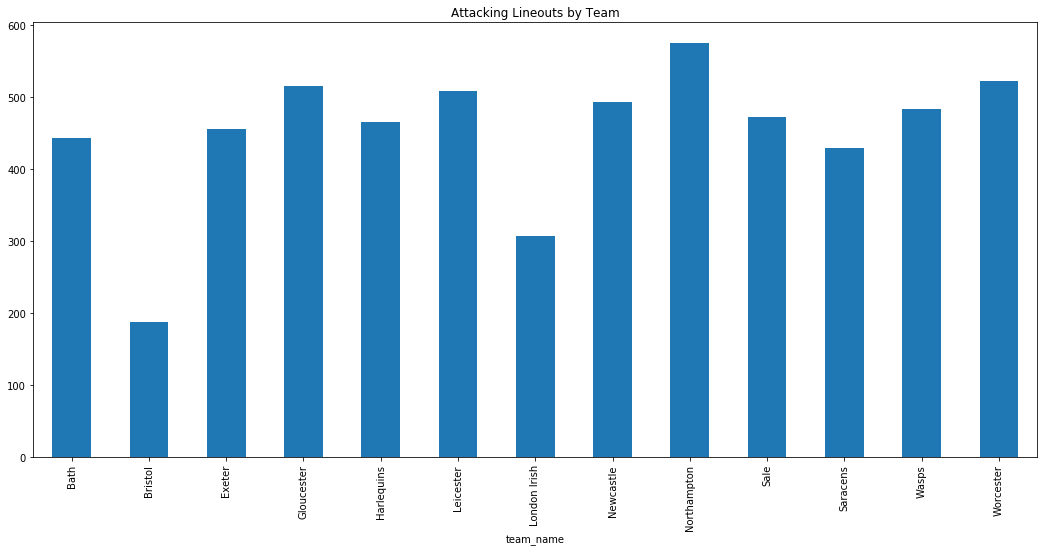

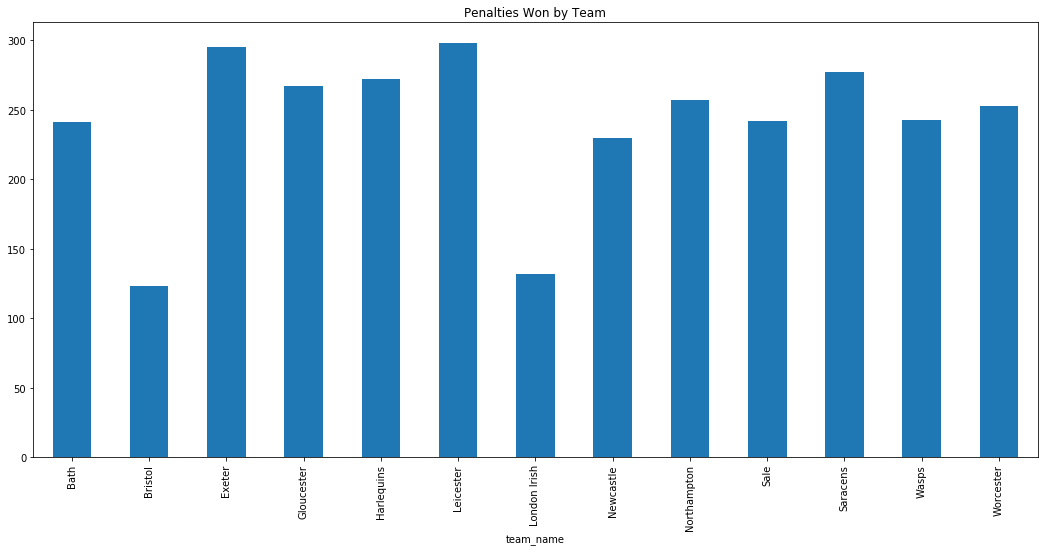

In [46]:
# QA plots 
df.groupby('team_name')['lineout_throw'].sum().plot.bar(title='Attacking Lineouts by Team', figsize=(18,8))
plt.show()
df.groupby('team_name').sum()['penalty_won'].plot.bar(title='Penalties Won by Team', figsize=(18,8))
plt.show()


# The Expected Value of a Lineout

We begin by calulating for each zone 

$$
\frac{@S^{lineout}_{try}}{\#S^{lineout}}
$$

and

$$
\frac{\#S^{lineout}_{try}}{\#S^{lineout}}
$$

Trys from Lineouts 11.89% 


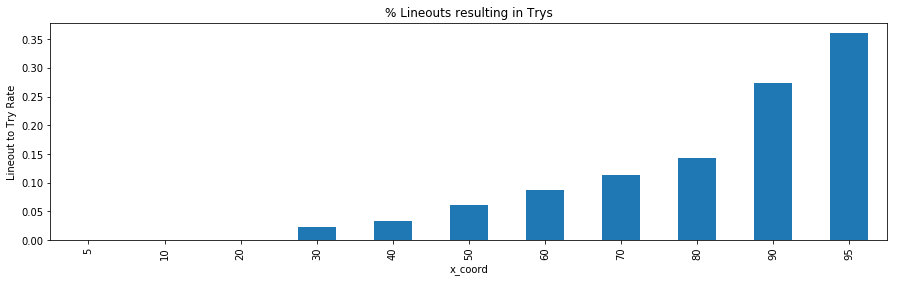

Pentaly or Dropkick from Lineouts 6.22% 


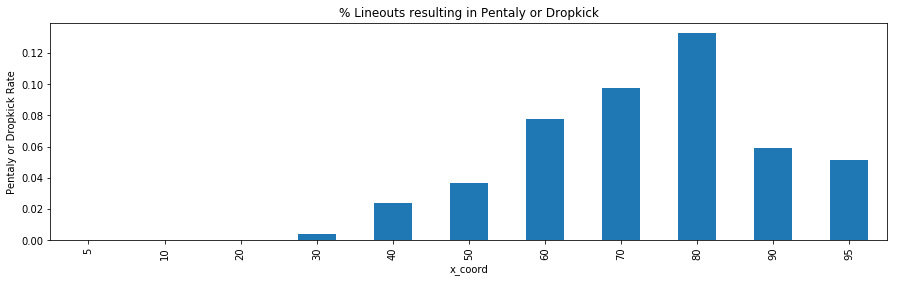

Points from a Lineout 18.11% 


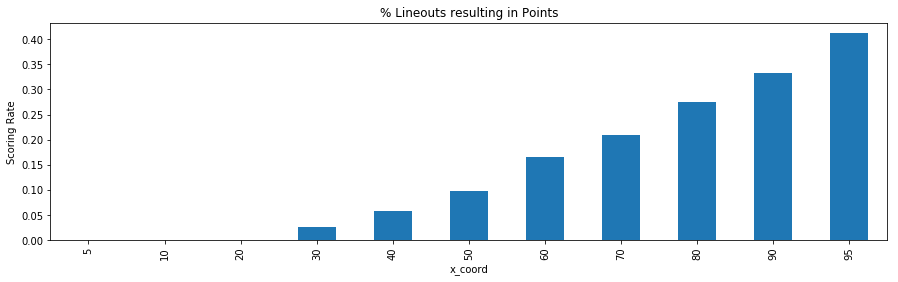

In [47]:
# select lineouts 
lineouts = df.query("start_event == 'Lineout' and x_coord > 0 and x_coord < 100")
lineouts_with_try = df.query("start_event == 'Lineout' and points >= 5 ")
lineouts_with_pen = df.query("start_event == 'Lineout' and points == 3")

lineout_to_try_rate = ((lineouts_with_try.groupby('x_coord')['team_name'].count())/\
 (lineouts.groupby('x_coord')['team_name'].count())).fillna(0)

lineout_to_try_rate.plot.bar(title='% Lineouts resulting in Trys',figsize=(15,4))
plt.ylabel('Lineout to Try Rate')

print('Trys from Lineouts %2.2f%% ' % (len(lineouts_with_try)/len(lineouts)*100) )

plt.show()

lineout_to_pen_rate = ((lineouts_with_pen.groupby('x_coord')['team_name'].count())/\
 (lineouts.groupby('x_coord')['team_name'].count())).fillna(0)

lineout_to_pen_rate.plot.bar(title='% Lineouts resulting in Pentaly or Dropkick',figsize=(15,4))
plt.ylabel('Pentaly or Dropkick Rate')

print('Pentaly or Dropkick from Lineouts %2.2f%% ' % (len(lineouts_with_pen)/len(lineouts)*100) )

plt.show()

lineout_to_points_rate = ((lineouts_with_pen.groupby('x_coord')['team_name'].count() + lineouts_with_try.groupby('x_coord')['team_name'].count())/\
 (lineouts.groupby('x_coord')['team_name'].count())).fillna(0)

lineout_to_points_rate.plot.bar(title='% Lineouts resulting in Points',figsize=(15,4))
plt.ylabel('Scoring Rate')

print('Points from a Lineout %2.2f%% ' % ((len(lineouts_with_try) + len(lineouts_with_pen) ) /len(lineouts)*100) )

plt.show()


In [48]:
lineout_to_points_rate

x_coord
5     0.000000
10    0.000000
20    0.000000
30    0.026718
40    0.058000
50    0.097913
60    0.165673
70    0.210201
80    0.275613
90    0.333333
95    0.412371
Name: team_name, dtype: float64

In [49]:
lineout_to_try_rate

x_coord
5     0.000000
10    0.000000
20    0.000000
30    0.022901
40    0.034000
50    0.060995
60    0.088200
70    0.112828
80    0.142857
90    0.274029
95    0.360825
Name: team_name, dtype: float64

In [50]:
lineout_to_pen_rate

x_coord
5     0.000000
10    0.000000
20    0.000000
30    0.003817
40    0.024000
50    0.036918
60    0.077473
70    0.097372
80    0.132756
90    0.059305
95    0.051546
Name: team_name, dtype: float64

Expected Value Lineouts 0.77 


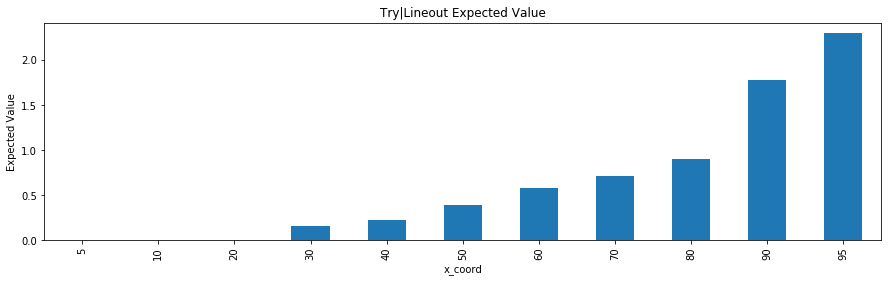

In [51]:
# select lineouts 
lineouts = df.query("start_event == 'Lineout' ")
lineouts_with_points = df.query("start_event == 'Lineout' and points >= 5 ")

lineout_expected_value = ((lineouts_with_points.groupby('x_coord')['points'].sum())/\
 (lineouts.groupby('x_coord')['team_name'].count())).fillna(0)

lineout_expected_value.plot.bar(title='Lineout Expected Value|Try',figsize=(15,4))
plt.ylabel('Expected Value')

print('Expected Value Lineouts %2.2f ' % ((lineouts_with_points.groupby('x_coord')['points'].sum().sum())/len(lineouts)) )

plt.show()

Counting repeated Lineouts from penaltys close to the line as one lineout

Expected Value Lineouts 2.26 


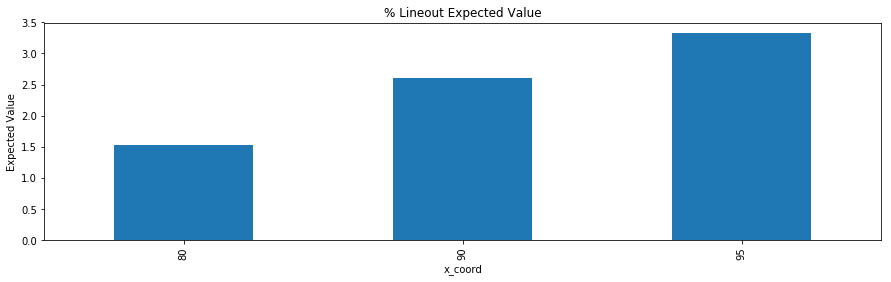

In [52]:
# select lineouts 
lineouts = df.query("start_event == 'Lineout' and end_event != 'End Pen Won' and (x_coord_end > 70 and x_coord > 70)")
lineouts_with_points = df.query("start_event == 'Lineout' and points >= 5 and (x_coord_end > 70 and x_coord > 70) ")

lineout_expected_value_2 = ((lineouts_with_points.groupby('x_coord')['points'].sum())/\
 (lineouts.groupby('x_coord')['team_name'].count())).fillna(0)

lineout_expected_value_2.plot.bar(title='% Lineout Expected Value',figsize=(15,4))
plt.ylabel('Expected Value')

print('Expected Value Lineouts %2.2f ' % ((lineouts_with_points.groupby('x_coord')['points'].sum().sum())/len(lineouts)) )

plt.show()

In [53]:
lineout_expected_value = lineout_expected_value.loc[:70].append(lineout_expected_value_2)

Text(0, 0.5, 'Expected Value')

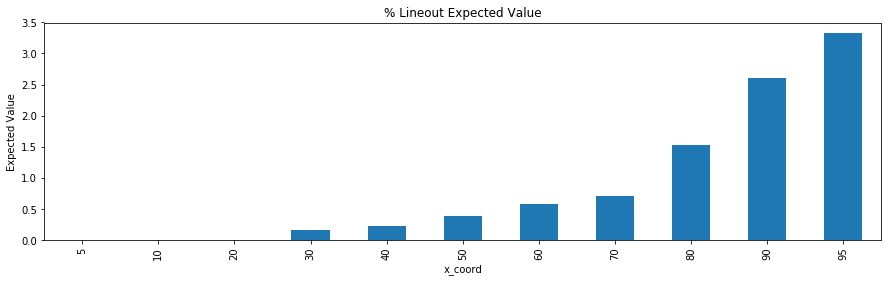

In [54]:
lineout_expected_value.plot.bar(title='% Lineout Expected Value',figsize=(15,4))
plt.ylabel('Expected Value')

Finally taking yellow cards award from repearted pentalies which according to https://www.rugbyworld.com/tournaments/european-champions-cup/stats-yellow-cards-really-bad-39058 are worth between 3.5 to 4.5 points

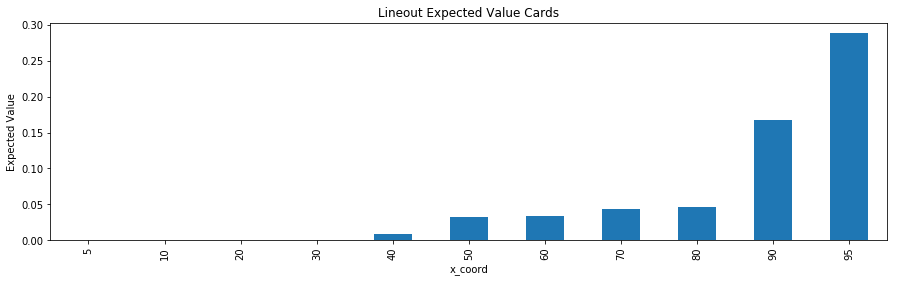

In [55]:
# select lineouts 
lineouts = df.query("start_event == 'Lineout' ")
lineouts_with_cards = df.query("start_event == 'Lineout' and yellow_card >= 1 ")

lineout_with_cards = ((lineouts_with_cards.groupby('x_coord')['team_name'].count()*4.0)/\
 (lineouts.groupby('x_coord')['team_name'].count())).fillna(0)

lineout_with_cards.plot.bar(title='Lineout Expected Value Cards',figsize=(15,4))
plt.ylabel('Expected Value')

plt.show()

In [56]:
lineout_expected_value = lineout_expected_value + lineout_with_cards

And finally our expected value of Try from a Lineout is

Text(0, 0.5, 'Expected Value')

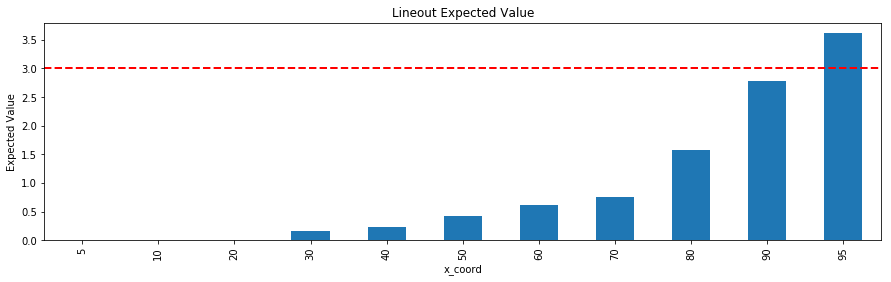

In [57]:
ax = lineout_expected_value.plot.bar(title='Lineout Expected Value',figsize=(15,4))
ax.axhline(y=3, xmin=0, xmax=90, color='r', linestyle='--', lw=2)
plt.ylabel('Expected Value')

In [58]:
lineout_expected_value

x_coord
5     0.000000
10    0.000000
20    0.000000
30    0.160305
40    0.234000
50    0.426966
60    0.607867
70    0.760433
80    1.571975
90    2.775474
95    3.617018
dtype: float64

Repeating the proccess for probablity of scoring points

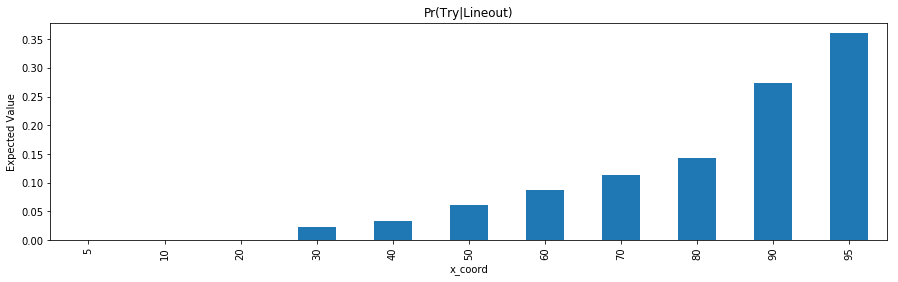

In [59]:

# select lineouts 
lineouts = df.query("start_event == 'Lineout' ")
lineouts_with_points = df.query("start_event == 'Lineout' and points >= 5 ")

lineout_prob = ((lineouts_with_points.groupby('x_coord')['points'].count())/\
 (lineouts.groupby('x_coord')['team_name'].count())).fillna(0)

lineout_prob.plot.bar(title='Pr(Try|Lineout)',figsize=(15,4))
plt.ylabel('Expected Value')

plt.show()



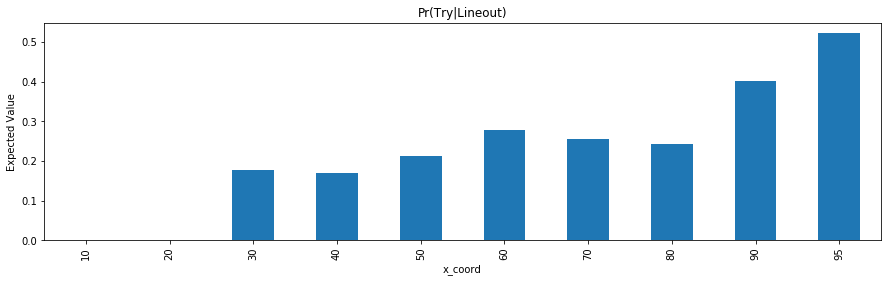

In [60]:
# select lineouts 
lineouts = df.query("start_event == 'Lineout' and end_event != 'End Pen Won' and (x_coord_end > 70 )")
lineouts_with_points = df.query("start_event == 'Lineout' and points >= 5 and (x_coord_end > 70 ) ")

lineout_prob2 = ((lineouts_with_points.groupby('x_coord')['points'].count())/\
 (lineouts.groupby('x_coord')['team_name'].count())).fillna(0)

lineout_prob2.plot.bar(title='Pr(Try|Lineout)',figsize=(15,4))
plt.ylabel('Expected Value')

plt.show()

Text(0, 0.5, 'Expected Value')

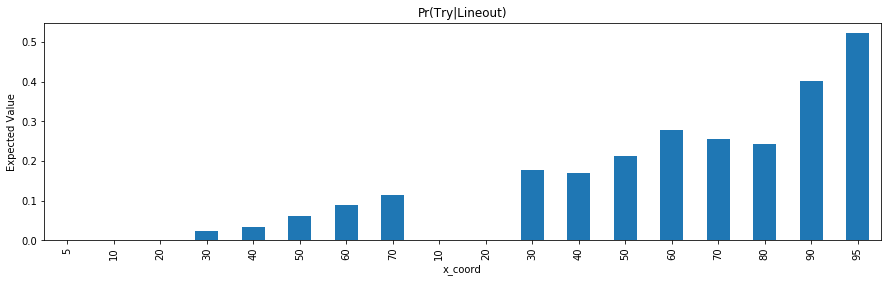

In [61]:
lineout_prob = lineout_prob.loc[:70].append(lineout_prob2)
lineout_prob.plot.bar(title='Pr(Try|Lineout)',figsize=(15,4))
plt.ylabel('Expected Value')

# Kicking Accuracy


As a team can choice to kick for goal or not when awarded a penatly measure success rate of penalty kicks can be misleading with teams avoiding hard kick for goal. A similar problem exists for with a team able to choose the distance from which to take a conversions. 

In [62]:
pen = len(df.query("end_event == 'End Pen Won' and goal_kick > 0"))
pen_kicked = len(df.query("end_event == 'End Pen Won' and goal_success > 0"))

print('Penalty\'s Kicked %2.2f%% ' % (pen_kicked/pen*100) )

Penalty's Kicked 84.41% 


In [63]:
trys = len(df.query("end_event == 'End Try' "))
conversions = len(df.query("end_event == 'End Try' and goal_success > 0"))

kicking_rate = conversions/trys

print('Conversions %2.2f%% ' % (kicking_rate*100) )

Conversions 72.28% 


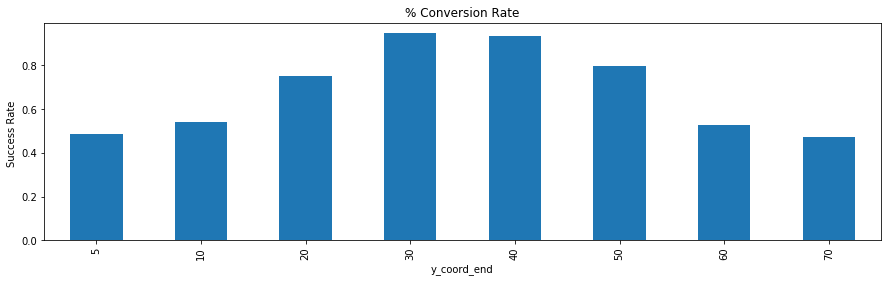

In [64]:
# select lineouts 

trys = df.query("end_event == 'End Try' ")
conversions = df.query("end_event == 'End Try' and goal_success > 0")

kicking_rate = ((conversions.groupby('y_coord_end')['team_name'].count())/\
 (trys.groupby('y_coord_end')['team_name'].count())).fillna(0)

kicking_rate.plot.bar(title='% Conversion Rate',figsize=(15,4))
plt.ylabel('Success Rate ')

plt.show()

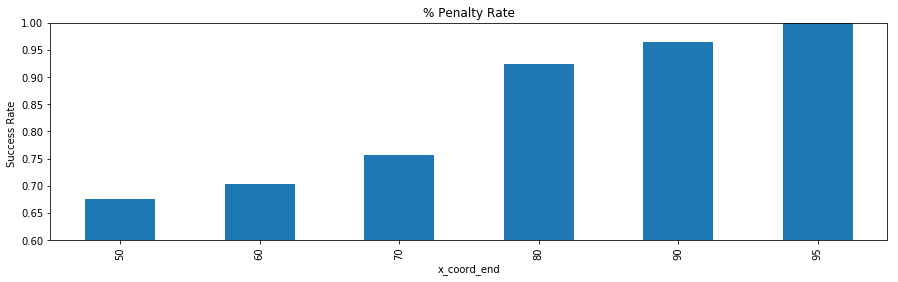

In [65]:
# select lineouts 
trys = df.query("end_event == 'End Pen Won' and goal_kick > 0 ")
conversions = df.query("end_event == 'End Pen Won' and goal_success > 0")

kicking_rate = ((conversions.query('x_coord_end > 48 and x_coord_end < 100').groupby('x_coord_end')['team_name'].count())/\
 (trys.query('x_coord_end > 48 and x_coord_end < 100').groupby('x_coord_end')['team_name'].count())).fillna(0)

kicking_rate.plot.bar(title='% Penalty Rate',figsize=(15,4))
plt.ylabel('Success Rate ')

plt.ylim((0.6,1))

plt.show()

In [68]:
empty_pitch()

(array([ 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95]),
 array([ 5, 10, 20, 30, 40, 50, 60, 70]))

We require is a combinded measure that uses conversion for accuracy and pentalty goals for power. This is achived via the formula 

\begin{equation*}
Pr(Goal \space Kick|(x,y)) = Pr(Conversion|(x,y)*Pr(Penatly \space Kick|(x,y))
\end{equation*}

In [77]:
#functions we are going to need 
def empty_pitch():
    x_coord = np.linspace(0,100,100)
    tmp = pd.Series(x_coord)
    x_coord = np.unique(tmp.apply(Zones))

    y_coord = np.linspace(0,70,70)
    tmp = pd.Series(y_coord)
    y_coord = np.unique(tmp.apply(Zones))
    
    return (x_coord,y_coord)

def create_probs(x_coord, y_coord,kicking_rate_length,kicking_rate_width,points):
    rows = []
    for y in y_coord:
        row = []
        for x in x_coord:
            try:
                if x >= 95 and (y < 30 or y > 40) : 
                    row.append(0)
                elif x >= 90 and (y < 20 or y >= 60) : 
                    row.append(0)    
                elif x <= 50 and (y < 10 or y > 50) : 
                    row.append(0)  
                elif x <= 40 and (y < 10 or y > 50) : 
                    row.append(0)  
                else:
                    row.append(kicking_rate_length[x] * kicking_rate_width[y]*points)
            except:
                row.append(0)
        rows.append(row)

    tmp = pd.DataFrame(rows,columns=x_coord)
    tmp.index = y_coord

    return tmp    

def kicking_success(df,points=1):
    trys = df.query("end_event == 'End Try' ")
    conversions = df.query("end_event == 'End Try' and goal_success > 0")

    kicking_rate_width = ((conversions.groupby(['y_coord_end'])['team_name'].count())/\
     (trys.groupby(['y_coord_end'])['team_name'].count())).fillna(0)
    trys = df.query("end_event == 'End Pen Won' and goal_kick > 0 ")
    conversions = df.query("end_event == 'End Pen Won' and goal_success > 0")

    kicking_rate_length = ((conversions.groupby(['x_coord_end'])['team_name'].count())/\
     (trys.groupby(['x_coord_end'])['team_name'].count())).fillna(0)

    x_coord,y_coord = empty_pitch()
    
    tmp = create_probs(x_coord, y_coord,kicking_rate_length,kicking_rate_width,points)

    return tmp


def draw_line(x,y,ls='-'):
    line = plt.Line2D(x, y, lw=2.5,color='white',ls=ls)
    plt.gca().add_line(line)

def draw_pitch():

    Pitch = plt.Rectangle([0,0], width = 100, height = 70, fill = True,color='green')
    plt.gca().add_patch(Pitch)
        
    #halfway line
    draw_line((50, 50), (0, 70))

    #22m lines
    draw_line((22, 22), (0, 70))    
    draw_line((100-22, 100-22), (0, 70))
    
    #5m lines
    draw_line((5, 5), (2.5, 7.5))
    draw_line((5, 5), (62.5, 67.5))
    draw_line((95, 95), (2.5, 7.5))
    draw_line((95, 95), (62.5, 67.5))
    
    #10m lines
    draw_line((40, 40), (0, 70),ls='--')    
    draw_line((60, 60), (0, 70),ls='--')

    
    #15m lines
    draw_line((0, 100), (5, 5),ls='--')    
    draw_line((0, 100), (65, 65),ls='--')
    draw_line((0, 100), (15, 15), ls='--')
    draw_line((0, 100), (55, 55), ls='--')

    plt.ylim(0, 70)
    plt.xlim(0, 100)


def heatmap(hmap,title = "",negative=False):
    fig=plt.figure() #set up the figures
    fig.set_size_inches(17, 8)
    ax=fig.add_subplot(1,1,1)
    draw_pitch() #overlay our different objects on the pitch


    plt.title(title)

    scale = np.array([100,70])
    ax.imshow(hmap.values, zorder=1, aspect="auto", extent=(0,scale[0],0,scale[1]), 
              cmap=sns.palplot(sns.dark_palette("red", 50)),alpha=0.75,interpolation='lanczos')

    offs = np.array([scale[0]/hmap.values.shape[1], scale[1]/hmap.values.shape[0]])
    
    for pos, val in np.ndenumerate(hmap.values):
        ax.annotate(f"{val:.2f}", xy=np.array(pos)[::-1]*offs+offs/2, ha="center", va="center",color='black')


    plt.show()

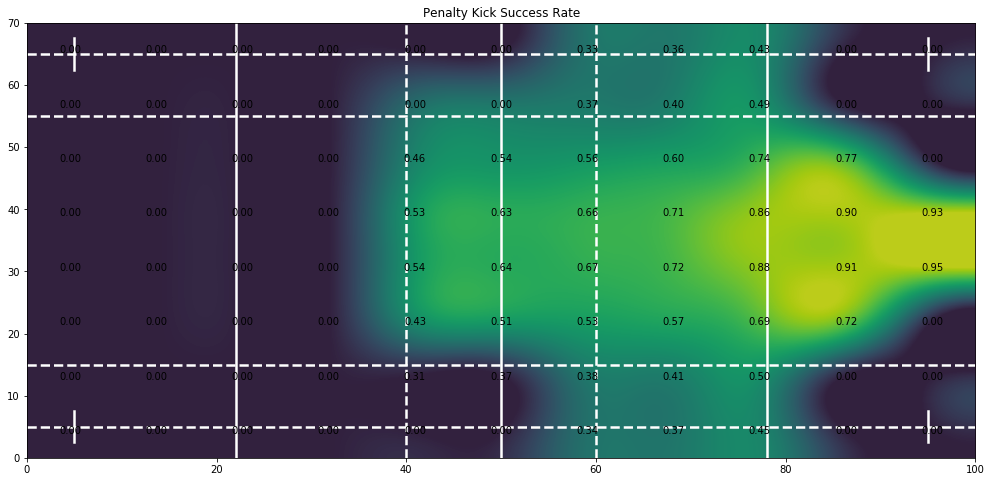

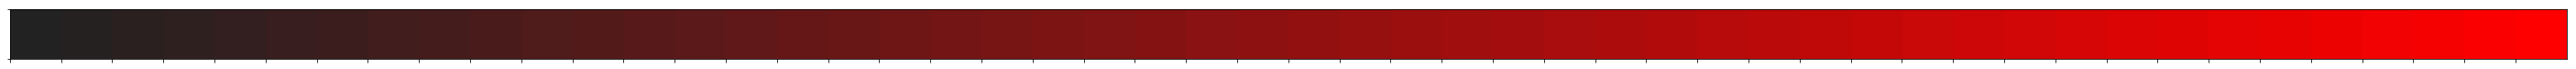

In [78]:
goal_kick_pr = kicking_success(df)
heatmap(goal_kick_pr,title='Penalty Kick Success Rate')

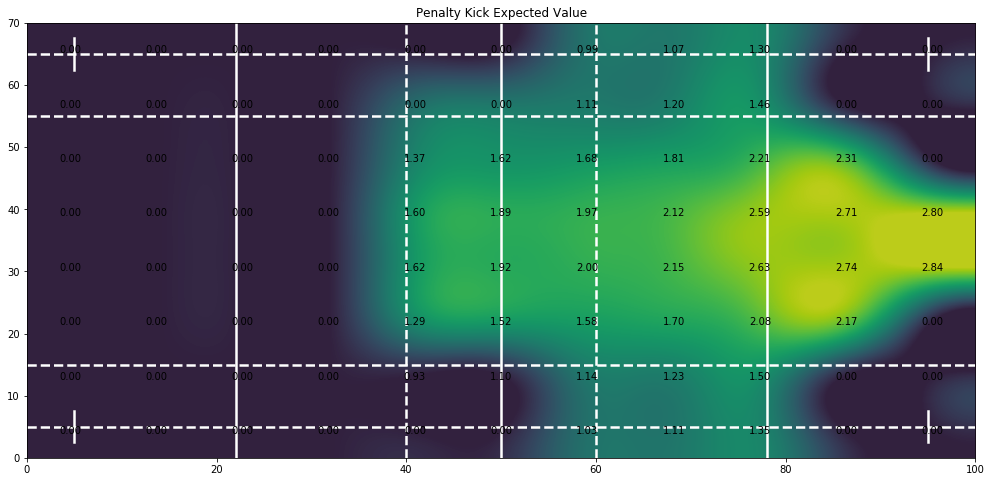

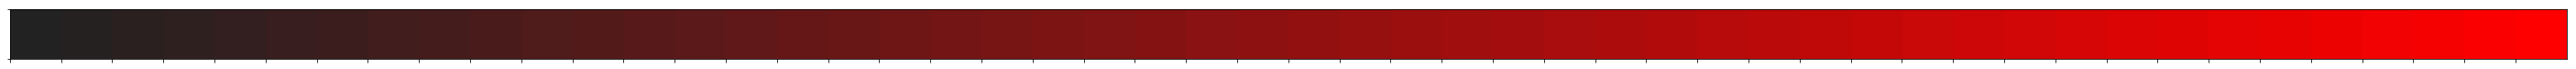

In [79]:
goal_kick_expected_value = kicking_success(df,points=3)
heatmap(goal_kick_expected_value,title='Penalty Kick Expected Value')

# Kick to Touch

Given a team does not take Lineout inline with where they recieved the penalty we need to calculate the expected  distance a team will kick the ball down field to setup the lineout.  

For example if a team received a penalty at (50,50) they could kick for goal (a 64% probablity of scoring 3 points) or they could kick the ball into touch X meters  down field. If they have a kicker able to kick the ball 45m down field then they will receive a Lineout 5m from the Try line which has a 50% probablity of resulting in a try. This will mean

\begin{equation*}
Pr(points|Goal \space Kick) \gt Pr(points|Lineout)
\end{equation*}

but as a Try is worth at least 5 points and a Goal Kick worth 3 


\begin{equation*}
0.63*3 \lt 0.5*5
\end{equation*}

\begin{equation*}
1.89 \lt 2.5
\end{equation*}

the expected value of a Lineout is worth more than a Goal Kick

In [29]:
pen_kicks_touch = pd.DataFrame()

for match in matches:
    kicks = match.events.query("event == 'Kick' and description == 'Penalty Kick' and event_type == 'Touch Kick' ")
    
    pen_kicks_touch = pd.concat([pen_kicks_touch,kicks], sort=False)
    
    pen_kicks_touch['x_coord'] = (pen_kicks_touch['x_coord']*1.0).apply(match._Zones)
    pen_kicks_touch['y_coord'] = (pen_kicks_touch['y_coord']*1.0).apply(match._Zones)
    
    pen_kicks_touch['x_coord_end'] = (pen_kicks_touch['x_coord_end']*1.0).apply(match._Zones)
    pen_kicks_touch['y_coord_end'] = (pen_kicks_touch['y_coord_end']*1.0).apply(match._Zones)

In [30]:
pen_kicks_touch['metres'] = pen_kicks_touch['x_coord_end'] - pen_kicks_touch['x_coord']
pen_kicks_touch = pen_kicks_touch.groupby(['x_coord','y_coord'])[['metres']].mean().reset_index()
pen_kicks_touch = pen_kicks_touch.pivot(index='y_coord',columns='x_coord').fillna(0)

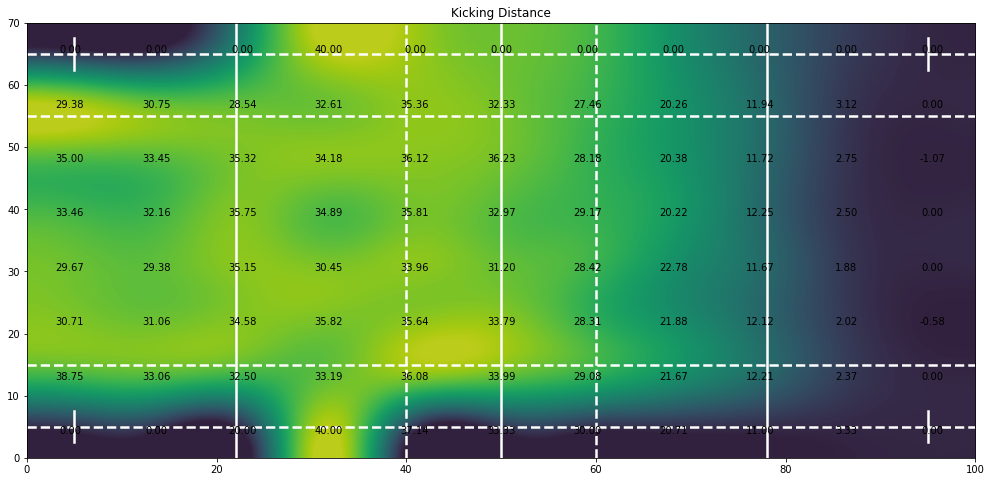

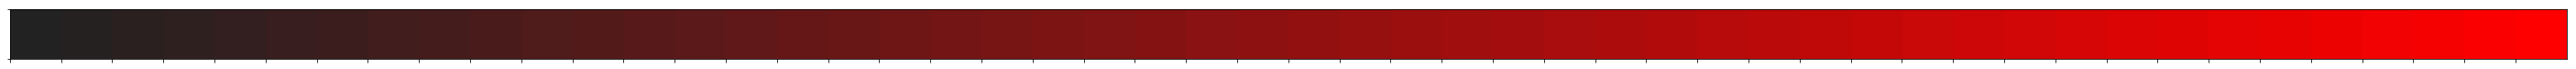

In [31]:
heatmap(pen_kicks_touch,title='Kicking Distance')

# Putting It Together

Finally we can put it all together to calulate with the probality of scoring points is higher when kicking to touch and the expected value. 

In [32]:
#expected value
pen_kicks_touch_steps = pen_kicks_touch/10
pen_kicks_touch_steps = pen_kicks_touch_steps.apply(np.ceil)
rows = []
for x in range(0,len(pen_kicks_touch_steps.columns)):
    row = []
    for y in range(0,len(pen_kicks_touch_steps)):
        row.append(lineout_expected_value.values[int(x + pen_kicks_touch_steps.values[y,x])] - goal_kick_expected_value.iloc[y,x])
        
    rows.append(row)

line_vs_kick_expected_value = pd.DataFrame(rows).T
line_vs_kick_expected_value.columns = pen_kicks_touch_steps.columns
line_vs_kick_expected_value.index = pen_kicks_touch_steps.index

In [33]:
#probablity of points 
rows = []
for x in range(0,len(pen_kicks_touch_steps.columns)):
    row = []
    for y in range(0,len(pen_kicks_touch_steps)):
        row.append(lineout_prob.values[int(x + pen_kicks_touch_steps.values[y,x])] - goal_kick_pr.iloc[y,x])
        
    rows.append(row)
    
line_vs_kick_pr = pd.DataFrame(rows).T
line_vs_kick_pr.columns = pen_kicks_touch_steps.columns
line_vs_kick_pr.index = pen_kicks_touch_steps.index

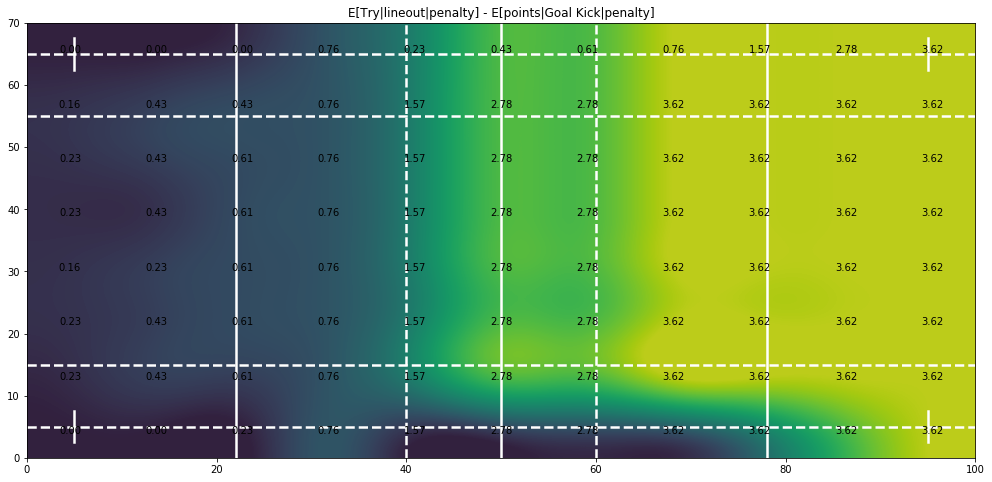

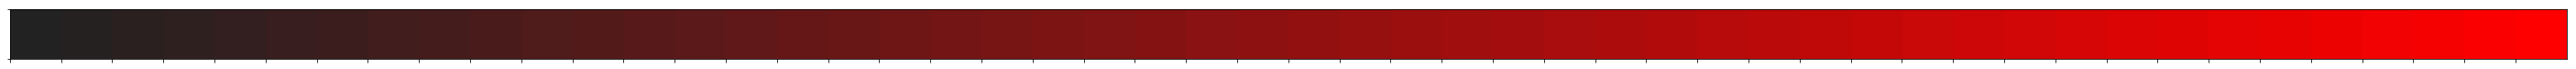

In [34]:
heatmap(line_vs_kick_expected_value,title="E[Try|lineout|penalty] - E[points|Goal Kick|penalty]")

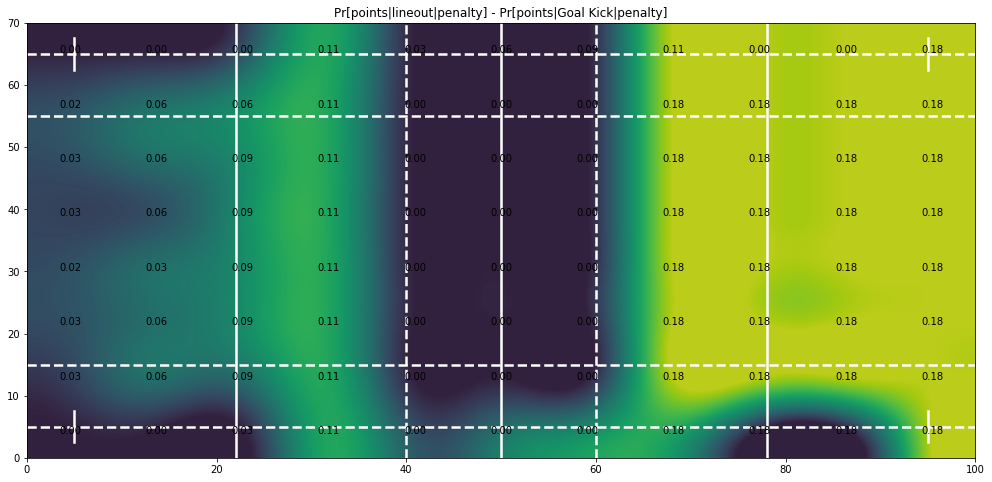

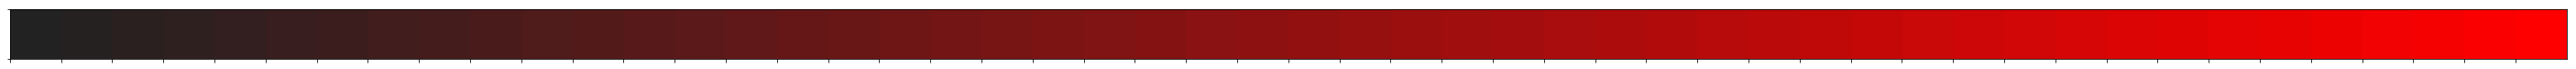

In [35]:
heatmap(line_vs_kick_pr,title="Pr[points|lineout|penalty] - Pr[points|Goal Kick|penalty]")

So from a expected value perspective you are always better off kicking for touch but you are more likely to score points for the center part of the pitch if you kick for goal. One question remains how match time does it take to score a try from a Lineout? 

In [36]:
df.query("lineout_throw > 0 and points >= 5 and (x_coord_end > 70 )")['length'].mean()

37.16

If we add some time to form the lineout say 1min we woudl need 1m40sec to score a try from a lineout. To play it safe lets say if there is 2min left in a match and you more than 3 points behind then kick for goal otherwise go for touch. 